In [ ]:
# подгрузить трастузумаб (есм2 тензоры, метаданные)
# выбрать Н точек
# посчитать попарные расстояния левенштейна между сиквенсами разных и одинаковых лейблов
# посчитать попарные расстояния есм2 между сиквенсами разных и одинаковых лейблов
# сравнить попарные расстояния есм2 между сиквенсами разных и одинаковых лейблов
# посчитать корреляцию между расстояниями левенштейна и есм2

# -------------------------------------------------------------

# подгрузить айрецептор
# выбрать Н точек

# **Load libraries**

In [ ]:
!pip install python-Levenshtein datashader bokeh holoviews scikit-image colorcet umap-learn tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.4 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=df4852aef766e0bebab5240a39fa20db43fd41109069c41a5e3b6beb8c1e6c64
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from umap import UMAP
import matplotlib.pyplot as plt
import pandas as pd
from scipy import linalg
import torch
from sklearn.manifold import TSNE
import umap.plot
import Levenshtein as lev
from sklearn.cluster import DBSCAN
from sklearn.preprocessing  import MinMaxScaler
from sklearn.cluster import OPTICS
from sklearn.decomposition import PCA
from scipy.spatial import distance
from tqdm import tqdm
from scipy.stats import pearsonr
from scipy.stats import mannwhitneyu
from scipy.spatial.distance import jensenshannon

/usr/local/lib/python3.10/dist-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [ ]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).

    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1:    The mean of the activations of preultimate layer of the
               CHEMNET (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2:    The mean of the activations of preultimate layer of the
               CHEMNET (like returned by the function 'get_predictions')
               for real samples.
    -- sigma1: The covariance matrix of the activations of preultimate layer
               of the CHEMNET (like returned by the function 'get_predictions')
               for generated samples.
    -- sigma2: The covariance matrix of the activations of preultimate layer
               of the CHEMNET (like returned by the function 'get_predictions')
               for real samples.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert (
        mu1.shape == mu2.shape
    ), "Training and test mean vectors have different lengths"
    assert (
        sigma1.shape == sigma2.shape
    ), "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            #raise ValueError("Imaginary component {}".format(m))
            print("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

In [ ]:
def get_w2(act1, act2):

    """Calculate w2 between two sets

    Args:
        act1: First set
        act2: Second set

    Returns:
        float: The FCD score
    """

    mu1 = np.mean(act1, axis=0)
    sigma1 = np.cov(act1.T)

    mu2 = np.mean(act2, axis=0)
    sigma2 = np.cov(act2.T)

    fcd_score = calculate_frechet_distance(
        mu1=mu1, mu2=mu2, sigma1=sigma1, sigma2=sigma2
    )

    return fcd_score

In [ ]:
def norm_dist(seq1, seq2):
    lev_dist = lev.distance(seq1, seq2)
    return 2*lev_dist/(len(seq1) + len(seq2) + lev_dist)

norm_dist('lew', 'lv')

0.5714285714285714

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# **Load sequences and tensors**

In [ ]:
seqs = pd.read_csv(f'/content/drive/MyDrive/Oslo/data/paper/FASTA/combined_distinct_heavy.csv', sep=';')
seqs

,index,seq
0,1,QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMSWIRQAPGKGLE...
1,2,QVQLVESGGGVVQPGRSLRLSCAASGFTFSSYAMHWVRQAPGKGLE...
2,3,EVQLVESGGGLVKPGGSLTLSCAVSGFTFKNAWMSWVRQAPGKGLE...
3,4,EVQLVESGGALVKPGGSLRLSCVVSGLTFTDAYMIWVRQAPGKGLE...
4,5,QEELVEAGGTVVQPGRSLGLSCAASGFSFSNYLMHWVRQTPGKGLE...
...,...,...
868515,868516,QRQLVQSGAEVKKPGASVKVSCKASGYTFTSYAIHWVRQAPGQRLE...
868516,868517,QRQLVQSGAEVKKPGASVKVSCKASGYTFTSYAIHWVRQAPGQRLE...
868517,868518,QVQLVQSGAEVGKPGASVKVSCKASGYTFTSYAIHWVRQAPGQRLE...
868518,868519,QCQLVQSGAEVKKPGASVKVSCKASGYTFTSYAIHWVRQAPGQRLE...


In [ ]:
tensors = torch.load(f'drive/MyDrive/Oslo/data/paper/output/esm2/H_FULL.pt').numpy()
tensors

array([[-0.07238457, -0.02844979, -0.04121361, ..., -0.11651975,
        -0.00999547,  0.09422897],
       [-0.0550065 , -0.0440774 , -0.06432801, ..., -0.14327888,
         0.00822941,  0.07717079],
       [-0.06217894, -0.03181529, -0.07133153, ..., -0.12185933,
        -0.01029811,  0.07998823],
       ...,
       [-0.00965859, -0.099021  , -0.10169315, ..., -0.15144235,
        -0.01826129,  0.09198308],
       [-0.01592757, -0.09778959, -0.10946459, ..., -0.16225791,
        -0.01690584,  0.09236693],
       [-0.0151915 , -0.09777823, -0.10601508, ..., -0.15625605,
        -0.02261259,  0.10010593]], dtype=float32)

In [ ]:
tensors_df = pd.DataFrame({
    'id': np.arange(1, len(tensors) + 1),
    'embedding': list(tensors)  # Convert the array of arrays into a list to be stored in the DataFrame
})

tensors_df

,id,embedding
0,1,"[-0.07238457, -0.028449792, -0.04121361, 0.231..."
1,2,"[-0.055006504, -0.0440774, -0.06432801, 0.2275..."
2,3,"[-0.062178936, -0.031815287, -0.07133153, 0.18..."
3,4,"[-0.08577644, -0.04220343, -0.028878685, 0.184..."
4,5,"[-0.06308087, -0.033702124, -0.0590733, 0.1946..."
...,...,...
868515,868516,"[-0.014612577, -0.092771105, -0.10426267, 0.22..."
868516,868517,"[-0.016627064, -0.09373432, -0.106812835, 0.22..."
868517,868518,"[-0.00965859, -0.099020995, -0.10169315, 0.226..."
868518,868519,"[-0.015927574, -0.097789586, -0.109464586, 0.2..."


In [ ]:
seqs = seqs.rename(columns={'index': 'id'})
seqs = seqs.rename(columns={'seq': 'junction_aa'})
seqs

,id,junction_aa
0,1,QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMSWIRQAPGKGLE...
1,2,QVQLVESGGGVVQPGRSLRLSCAASGFTFSSYAMHWVRQAPGKGLE...
2,3,EVQLVESGGGLVKPGGSLTLSCAVSGFTFKNAWMSWVRQAPGKGLE...
3,4,EVQLVESGGALVKPGGSLRLSCVVSGLTFTDAYMIWVRQAPGKGLE...
4,5,QEELVEAGGTVVQPGRSLGLSCAASGFSFSNYLMHWVRQTPGKGLE...
...,...,...
868515,868516,QRQLVQSGAEVKKPGASVKVSCKASGYTFTSYAIHWVRQAPGQRLE...
868516,868517,QRQLVQSGAEVKKPGASVKVSCKASGYTFTSYAIHWVRQAPGQRLE...
868517,868518,QVQLVQSGAEVGKPGASVKVSCKASGYTFTSYAIHWVRQAPGQRLE...
868518,868519,QCQLVQSGAEVKKPGASVKVSCKASGYTFTSYAIHWVRQAPGQRLE...


In [ ]:
df = pd.merge(seqs, tensors_df, on='id')
df = df[['junction_aa', 'id', 'embedding']]
df['junction_length'] = df['junction_aa'].apply(len)
#df = df[df['junction_length'] <= 40]

df

,junction_aa,id,embedding,junction_length
0,QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMSWIRQAPGKGLE...,1,"[-0.07238457, -0.028449792, -0.04121361, 0.231...",117
1,QVQLVESGGGVVQPGRSLRLSCAASGFTFSSYAMHWVRQAPGKGLE...,2,"[-0.055006504, -0.0440774, -0.06432801, 0.2275...",122
2,EVQLVESGGGLVKPGGSLTLSCAVSGFTFKNAWMSWVRQAPGKGLE...,3,"[-0.062178936, -0.031815287, -0.07133153, 0.18...",121
3,EVQLVESGGALVKPGGSLRLSCVVSGLTFTDAYMIWVRQAPGKGLE...,4,"[-0.08577644, -0.04220343, -0.028878685, 0.184...",121
4,QEELVEAGGTVVQPGRSLGLSCAASGFSFSNYLMHWVRQTPGKGLE...,5,"[-0.06308087, -0.033702124, -0.0590733, 0.1946...",127
...,...,...,...,...
868515,QRQLVQSGAEVKKPGASVKVSCKASGYTFTSYAIHWVRQAPGQRLE...,868516,"[-0.014612577, -0.092771105, -0.10426267, 0.22...",226
868516,QRQLVQSGAEVKKPGASVKVSCKASGYTFTSYAIHWVRQAPGQRLE...,868517,"[-0.016627064, -0.09373432, -0.106812835, 0.22...",226
868517,QVQLVQSGAEVGKPGASVKVSCKASGYTFTSYAIHWVRQAPGQRLE...,868518,"[-0.00965859, -0.099020995, -0.10169315, 0.226...",226
868518,QCQLVQSGAEVKKPGASVKVSCKASGYTFTSYAIHWVRQAPGQRLE...,868519,"[-0.015927574, -0.097789586, -0.109464586, 0.2...",226


In [ ]:
df_1000 = df.sample(n=1000, random_state=42)

df_1000

,junction_aa,id,embedding,junction_length
809664,QLQLQESGPGLVKPSETLSLTCTVSDGSISSSTFYWGWIRQPPGKG...,809665,"[-0.038877062, -0.01646605, -0.05389079, 0.180...",119
509713,EVQLVESGGGLVQPGGSLRLSCAASGFNIRTAYMSWVRQAPGKGLE...,509714,"[-0.068247296, -0.022689776, -0.053953942, 0.1...",119
717177,QVQLVQSGAEVKKPGSSVKVSCKASGGTFSSYAISWVRQAPGQGLE...,717178,"[-0.039497446, -0.04861216, -0.06625628, 0.243...",126
640482,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYAMHWVRQAPGQRLE...,640483,"[-0.04031954, -0.089296244, -0.12716447, 0.264...",120
842887,QVQLVQSGAEVKKPGSSVKVSCKASGGTFSSYAISWVRQAPGQGLE...,842888,"[-0.020889847, -0.03715615, -0.06075465, 0.242...",131
...,...,...,...,...
541295,QVQLVESGGGVVQPGRSLRLSCAASRFTFSRYGMHWVRQAPGKGLE...,541296,"[-0.079714336, -0.04275092, -0.051375557, 0.20...",123
44911,QVQLVESGGGVVQPGRSVRLSCAASGFTFSSYSMHWVRQAPGKGLE...,44912,"[-0.08752544, -0.042699732, -0.07552092, 0.209...",120
779447,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYYMHWVRQAPGQGLE...,779448,"[-0.040609714, -0.07058915, -0.11861389, 0.267...",120
763862,QLQLQESGPGLVKPSETLSLTCTVSGGSISSSSYYWGWIRQPPGKG...,763863,"[-0.040974066, -0.013088449, -0.07119221, 0.19...",122


# **Prepare the CDR3 file (optional)**

In [ ]:
df_1000['id'] = range(1, len(df_1000) + 1)

with open('/content/drive/MyDrive/Oslo/data/paper/FASTA/h_full_1000.fa', 'w') as file:
    for index, row in df_1000.iterrows():
        id = row['id']
        cdr_aa = row['junction_aa']

        # Write the FASTA entry
        file.write(f'>{id}\n{cdr_aa}\n')

In [ ]:
# Load ANARCI output

# Your CSV file path
filepath = '/content/drive/MyDrive/Oslo/data/paper/FASTA/h_full_1000.csv'

# Read the CSV
df = pd.read_csv(filepath)

# Locate your start and end columns
start = df.columns.get_loc('104')
end = df.columns.get_loc('118')

# Extract the columns between and including 'start' and 'end'
subset_df = df.iloc[:, start:end+1]

# Creating a new column as the concatenation of all columns of interest
df['concatenated'] = subset_df.apply(lambda row: ''.join(row.values.astype(str)).replace('-', ''), axis=1)

# Print the DataFrame to see the result
df

,Id,domain_no,hmm_species,chain_type,e-value,score,seqstart_index,seqend_index,identity_species,v_gene,...,120,121,122,123,124,125,126,127,128,concatenated
0,1,0,human,H,3.100000e-54,173.7,0,118,NaN,NaN,...,R,G,T,L,V,T,V,S,S,CARQGGDWYFDLW
1,2,0,human,H,6.200000e-58,185.6,0,118,NaN,NaN,...,Q,G,T,L,V,T,V,S,S,CARDPVATAKIFDYW
2,3,0,human,H,3.500000e-56,179.9,0,125,NaN,NaN,...,Q,G,T,M,V,T,V,S,S,CARLKLYYYDSSGYADAFDIW
3,4,0,human,H,9.600000e-58,185.0,0,119,NaN,NaN,...,Q,G,T,L,V,T,V,S,S,CARVWSWNYVGGGYW
4,5,0,human,H,2.200000e-54,174.1,0,130,NaN,NaN,...,Q,G,T,M,V,T,V,S,S,CARDSLFYYDSSGHTGGAPGDAFDIW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,0,human,H,3.800000e-59,189.6,0,122,NaN,NaN,...,Q,G,T,L,V,T,V,S,S,CARDLGGFGELYEVADYW
996,997,0,human,H,6.800000e-62,198.4,0,119,NaN,NaN,...,Q,G,T,L,V,T,V,S,S,CARAHSNSWGYFDCW
997,998,0,human,H,1.200000e-60,194.4,0,119,NaN,NaN,...,Q,G,T,T,V,T,V,S,S,CARFLSDYYYGMDVW
998,999,0,human,H,5.400000e-58,185.8,0,121,NaN,NaN,...,Q,G,T,L,V,T,V,S,S,CARGNWELLQTNFDYW


In [ ]:
seqs = df[['Id', 'concatenated']]
seqs.rename(columns={'concatenated': 'junction_aa', 'Id': 'id'}, inplace=True)

with open('/content/drive/MyDrive/Oslo/data/paper/FASTA/h_cdr3_1000.fa', 'w') as file:
    for index, row in seqs.iterrows():
        id = row['id']
        cdr_aa = row['junction_aa']

        # Write the FASTA entry
        file.write(f'>{id}\n{cdr_aa}\n')

seqs

<ipython-input-52-7e6a0e1c745c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seqs.rename(columns={'concatenated': 'junction_aa', 'Id': 'id'}, inplace=True)


,id,junction_aa
0,1,CARQGGDWYFDLW
1,2,CARDPVATAKIFDYW
2,3,CARLKLYYYDSSGYADAFDIW
3,4,CARVWSWNYVGGGYW
4,5,CARDSLFYYDSSGHTGGAPGDAFDIW
...,...,...
995,996,CARDLGGFGELYEVADYW
996,997,CARAHSNSWGYFDCW
997,998,CARFLSDYYYGMDVW
998,999,CARGNWELLQTNFDYW


In [ ]:
tensors = torch.load(f'drive/MyDrive/Oslo/data/paper/output/esm2/h_cdr3_1000.pt').numpy()
tensors

array([[ 0.02485422,  0.11601554,  0.07991279, ...,  0.05948324,
        -0.02896937,  0.10630076],
       [-0.00696654,  0.11806087, -0.00093265, ..., -0.01516249,
        -0.02784658, -0.02374419],
       [ 0.04563841,  0.08443011, -0.01499416, ...,  0.03037603,
        -0.06191053, -0.05416077],
       ...,
       [ 0.05444082,  0.07706161,  0.08327939, ..., -0.00907752,
        -0.06579438, -0.00645284],
       [ 0.04870265,  0.06942052,  0.12629364, ...,  0.02049257,
        -0.11556107,  0.03387634],
       [-0.03945449,  0.13563582,  0.0945468 , ...,  0.00884162,
         0.03956524,  0.01062269]], dtype=float32)

In [ ]:
tensors_df = pd.DataFrame({
    'id': np.arange(1, len(tensors) + 1),
    'embedding': list(tensors)  # Convert the array of arrays into a list to be stored in the DataFrame
})

tensors_df

,id,embedding
0,1,"[0.024854217, 0.11601554, 0.07991279, 0.106541..."
1,2,"[-0.006966541, 0.11806087, -0.0009326488, 0.11..."
2,3,"[0.045638412, 0.084430106, -0.014994156, 0.106..."
3,4,"[0.043396726, 0.058825713, 0.07563674, 0.06564..."
4,5,"[-0.013631576, 0.0886435, 0.014891686, 0.07356..."
...,...,...
995,996,"[0.0030212319, 0.07097423, 0.07818207, 0.03735..."
996,997,"[0.09846283, 0.09468936, 0.094535775, 0.117941..."
997,998,"[0.05444082, 0.07706161, 0.08327939, 0.1052197..."
998,999,"[0.04870265, 0.069420524, 0.12629364, 0.107459..."


In [ ]:
df_1000_cdr3 = pd.merge(seqs, tensors_df, on='id')

df_1000_cdr3

,id,junction_aa,embedding
0,1,CARQGGDWYFDLW,"[0.024854217, 0.11601554, 0.07991279, 0.106541..."
1,2,CARDPVATAKIFDYW,"[-0.006966541, 0.11806087, -0.0009326488, 0.11..."
2,3,CARLKLYYYDSSGYADAFDIW,"[0.045638412, 0.084430106, -0.014994156, 0.106..."
3,4,CARVWSWNYVGGGYW,"[0.043396726, 0.058825713, 0.07563674, 0.06564..."
4,5,CARDSLFYYDSSGHTGGAPGDAFDIW,"[-0.013631576, 0.0886435, 0.014891686, 0.07356..."
...,...,...,...
995,996,CARDLGGFGELYEVADYW,"[0.0030212319, 0.07097423, 0.07818207, 0.03735..."
996,997,CARAHSNSWGYFDCW,"[0.09846283, 0.09468936, 0.094535775, 0.117941..."
997,998,CARFLSDYYYGMDVW,"[0.05444082, 0.07706161, 0.08327939, 0.1052197..."
998,999,CARGNWELLQTNFDYW,"[0.04870265, 0.069420524, 0.12629364, 0.107459..."


# **Calculate pairwise distances**

In [ ]:
dataframe = df_1000_cdr3

# Initialize dictionaries to store distances
levenshtein_distances = {}
euclidean_distances = {}

total_pairs = len(dataframe) * (len(dataframe) - 1) / 2  # Calculates the total number of sequence pairs

# Calculate pairwise distances
with tqdm(total=total_pairs, desc='Calculating distances', unit='pair') as pbar:
    for i in range(len(dataframe) - 1):
        for j in range(i + 1, len(dataframe)):
            # Levenshtein distance for sequences
            seq1 = dataframe.iloc[i]['junction_aa']
            seq2 = dataframe.iloc[j]['junction_aa']
            # https://rapidfuzz.github.io/Levenshtein/levenshtein.html#distance
            levenshtein_distances[(i, j)] = norm_dist(seq1, seq2)

            # Euclidean distance for embeddings
            embed1 = dataframe.iloc[i]['embedding']
            embed2 = dataframe.iloc[j]['embedding']
            euclidean_distances[(i, j)] = distance.euclidean(embed1, embed2)

            # Update the progress bar
            pbar.update()

# Display the results
print("Pairwise Levenshtein distances:", levenshtein_distances)
print("Pairwise Euclidean distances:", euclidean_distances)

Calculating distances: 100%|██████████| 499500/499500.0 [03:22<00:00, 2465.85pair/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# Extract the distances from the dictionaries into lists
levenshtein_list = list(levenshtein_distances.values())
euclidean_list = list(euclidean_distances.values())

# Calculate the Pearson correlation coefficient
correlation, p_value = pearsonr(levenshtein_list, euclidean_list)

print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value of the correlation: {p_value}")

Pearson correlation coefficient: 0.3324765130835893
P-value of the correlation: 0.0


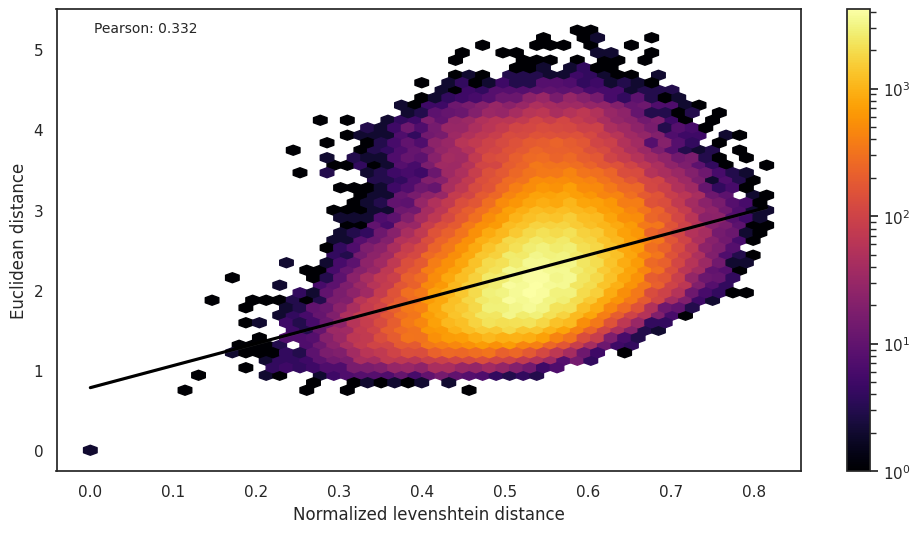

In [ ]:
sns.set_style("white")

plt.figure(figsize=(12, 6))

# Create a DataFrame
df_distances = pd.DataFrame({
    'Normalized levenshtein distance': levenshtein_list,
    'Euclidean distance': euclidean_list
})

# Hexbin plot
hb = plt.hexbin(df_distances['Normalized levenshtein distance'], df_distances['Euclidean distance'], gridsize=50, cmap='inferno', bins='log')
cb = plt.colorbar(hb)

# Regression line
sns.regplot(data=df_distances, x='Normalized levenshtein distance', y='Euclidean distance', scatter=False, color="black")

# Calculate the Pearson correlation coefficient separately
corr_coef, p_value = pearsonr(df_distances['Normalized levenshtein distance'], df_distances['Euclidean distance'])

# Annotate the plot with the Pearson correlation coefficient and p-value
plt.text(0.05, 0.95, f'Pearson: {corr_coef:.3f}', transform=plt.gca().transAxes, fontsize=10)

# Show the plot
plt.savefig('n_1000.png')
plt.show()

# **Load sequences and tensors - trastuzumab**

In [ ]:
seqs = pd.read_csv(f'/content/drive/MyDrive/Oslo/data/all_data/all_data.csv', sep=';')
seqs

<ipython-input-7-372f389bc945>:1: DtypeWarning: Columns (0,1,2,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  seqs = pd.read_csv(f'/content/drive/MyDrive/Oslo/data/all_data/all_data.csv', sep=';')


,Protein + Epitope,v_call,j_call,junction_aa,dataset,id,duplicate_count,affinity,d_call,c_call,repertoire_id,junction_length
0,S; RBD,IGHV3-53 (Human),IGHJ4 (Human),CARDLVVYGLDYW,covabdab,1,NaN,NaN,NaN,NaN,NaN,13
1,S; RBD,IGHV3-11 (Human),IGHJ4 (Human),CAREFDLTKIIMVPPYW,covabdab,2,NaN,NaN,NaN,NaN,NaN,17
2,S; RBD,IGHV3-30 (Human),IGHJ4 (Human),CARDSSGWHWGVPFDYW,covabdab,3,NaN,NaN,NaN,NaN,NaN,17
3,S; RBD,IGHV3-53 (Human),IGHJ3 (Human),CVRGSGGIHDAFDIW,covabdab,4,NaN,NaN,NaN,NaN,NaN,15
4,S; RBD,IGHV3-53 (Human),IGHJ4 (Human),CARVDPRYEGFDYW,covabdab,5,NaN,NaN,NaN,NaN,NaN,14
...,...,...,...,...,...,...,...,...,...,...,...,...
2134046,NaN,NaN,NaN,CVRNNTKGYSSSWFVAFDIW,maria,2134047,1.0,NaN,NaN,NaN,NaN,20
2134047,NaN,NaN,NaN,CATSSGSANYYYYYMDVW,maria,2134048,1.0,NaN,NaN,NaN,NaN,18
2134048,NaN,NaN,NaN,CAKGDPEIITMIVVVTKISLYW,maria,2134049,1.0,NaN,NaN,NaN,NaN,22
2134049,NaN,NaN,NaN,CASHPTTVTIHPHWFDPW,maria,2134050,1.0,NaN,NaN,NaN,NaN,18


In [ ]:
tensors = torch.load(f'drive/MyDrive/Oslo/data/all_data/output/esm2/all_data.pt').numpy()
tensors

array([[ 0.0165359 ,  0.09836441,  0.08451218, ...,  0.02045532,
        -0.00949972,  0.04278376],
       [ 0.03494602,  0.06543857,  0.02455574, ..., -0.03105022,
        -0.07298544, -0.00877932],
       [ 0.02155516,  0.11110472,  0.07370144, ...,  0.03026756,
        -0.02370827,  0.08511717],
       ...,
       [ 0.03574988,  0.03490529,  0.05695289, ...,  0.03252791,
        -0.03586698,  0.02588152],
       [ 0.01984302,  0.14281625,  0.01913723, ..., -0.06762866,
        -0.01449933, -0.06972364],
       [ 0.03005114,  0.07345476,  0.09382471, ...,  0.050596  ,
        -0.0268468 ,  0.05022966]], dtype=float32)

In [ ]:
len(tensors[0])

1280

In [ ]:
tensors_df = pd.DataFrame({
    'id': np.arange(1, len(tensors) + 1),
    'embedding': list(tensors)  # Convert the array of arrays into a list to be stored in the DataFrame
})

tensors_df

,id,embedding
0,1,"[0.016535902, 0.098364405, 0.08451218, 0.07570..."
1,2,"[0.034946017, 0.06543857, 0.024555739, 0.06877..."
2,3,"[0.021555165, 0.11110472, 0.07370144, 0.090482..."
3,4,"[0.0057980497, 0.090299375, 0.09269716, 0.0350..."
4,5,"[-0.007613844, 0.12992819, 0.003057226, 0.0977..."
...,...,...
2134046,2134047,"[0.031164575, 0.07445412, 0.11935415, 0.136152..."
2134047,2134048,"[0.06225334, 0.09700576, 0.04691232, 0.1647059..."
2134048,2134049,"[0.03574988, 0.03490529, 0.056952894, 0.064391..."
2134049,2134050,"[0.019843016, 0.14281625, 0.019137233, 0.00460..."


In [ ]:
df = pd.merge(seqs, tensors_df, on='id')
df = df[['junction_aa', 'id', 'embedding', 'dataset', 'affinity']]
df = df[df['dataset'] == 'trastuzumab']
df = df[df['affinity'] != 'mb']
df['junction_length'] = df['junction_aa'].apply(len)
df = df[df['junction_length'] <= 40]

df

,junction_aa,id,embedding,dataset,affinity,junction_length
11467,CSRIASVAFTCSLYW,11468,"[0.08607771, 0.1267628, 0.15658017, 0.15222932...",trastuzumab,lb,15
11468,CSRIASGLLTLYHYW,11469,"[0.08095949, 0.08205593, 0.09087815, 0.0948732...",trastuzumab,lb,15
11469,CSRWATFGLYAHRYW,11470,"[0.074350245, 0.10862581, 0.08118942, 0.079310...",trastuzumab,lb,15
11470,CSRWSMFGLYTFCYW,11471,"[0.11971326, 0.045084246, 0.15607142, 0.164883...",trastuzumab,lb,15
11471,CSRYVTNGFYAYHYW,11472,"[0.06607033, 0.069482096, 0.02638524, 0.105626...",trastuzumab,lb,15
...,...,...,...,...,...,...
345798,CSRWRAFRTYTFEYW,345799,"[0.0957916, 0.118075535, 0.1332415, 0.11102016...",trastuzumab,hb,15
345799,CSRWARARMYSYDYW,345800,"[0.090603486, 0.10823231, 0.06844074, 0.112363...",trastuzumab,hb,15
345800,CSRYKVSGHYALDYW,345801,"[0.049668964, 0.050600886, 0.09501328, 0.10028...",trastuzumab,hb,15
345801,CSRYIHVGFYAHVYW,345802,"[0.07180209, 0.0982526, 0.056150246, 0.0312086...",trastuzumab,hb,15


In [ ]:
df_hb = df[df['affinity'] == 'hb']
df_hb

,junction_aa,id,embedding,dataset,affinity,junction_length
173653,CSRWGGDGFTHLTYW,173654,"[0.038120218, 0.08169616, 0.120041564, 0.09792...",trastuzumab,hb,15
173654,CSRYTAPSFYTFDYW,173655,"[0.06599786, 0.15759282, 0.083128445, 0.172919...",trastuzumab,hb,15
173655,CSRWAAGRSYTFDYW,173656,"[0.039980598, 0.13780491, 0.08726641, 0.142348...",trastuzumab,hb,15
173656,CSRWAAGRFYAFDYW,173657,"[0.038433556, 0.14572363, 0.05692141, 0.121157...",trastuzumab,hb,15
173657,CSRWNAPSFYALNYW,173658,"[0.060799345, 0.12986624, 0.10121548, 0.190596...",trastuzumab,hb,15
...,...,...,...,...,...,...
345798,CSRWRAFRTYTFEYW,345799,"[0.0957916, 0.118075535, 0.1332415, 0.11102016...",trastuzumab,hb,15
345799,CSRWARARMYSYDYW,345800,"[0.090603486, 0.10823231, 0.06844074, 0.112363...",trastuzumab,hb,15
345800,CSRYKVSGHYALDYW,345801,"[0.049668964, 0.050600886, 0.09501328, 0.10028...",trastuzumab,hb,15
345801,CSRYIHVGFYAHVYW,345802,"[0.07180209, 0.0982526, 0.056150246, 0.0312086...",trastuzumab,hb,15


In [ ]:
df_lb = df[df['affinity'] == 'lb']
df_lb

,junction_aa,id,embedding,dataset,affinity,junction_length
11467,CSRIASVAFTCSLYW,11468,"[0.08607771, 0.1267628, 0.15658017, 0.15222932...",trastuzumab,lb,15
11468,CSRIASGLLTLYHYW,11469,"[0.08095949, 0.08205593, 0.09087815, 0.0948732...",trastuzumab,lb,15
11469,CSRWATFGLYAHRYW,11470,"[0.074350245, 0.10862581, 0.08118942, 0.079310...",trastuzumab,lb,15
11470,CSRWSMFGLYTFCYW,11471,"[0.11971326, 0.045084246, 0.15607142, 0.164883...",trastuzumab,lb,15
11471,CSRYVTNGFYAYHYW,11472,"[0.06607033, 0.069482096, 0.02638524, 0.105626...",trastuzumab,lb,15
...,...,...,...,...,...,...
173648,CSRYKDGGFYAKAYW,173649,"[-0.003322058, 0.11350301, 0.007520077, 0.1672...",trastuzumab,lb,15
173649,CSRGATTAFTRMCYW,173650,"[0.09133129, 0.04434262, 0.15079708, 0.1157826...",trastuzumab,lb,15
173650,CSRGAAQASTNSTYW,173651,"[0.047490355, 0.14121619, 0.13806246, 0.145991...",trastuzumab,lb,15
173651,CSRCCLFALYVFFYW,173652,"[0.09276049, 0.062364586, 0.16183639, 0.130448...",trastuzumab,lb,15


In [ ]:
df_hb_1000 = df_hb.sample(n=1000, random_state=42)
df_lb_1000 = df_lb.sample(n=1000, random_state=42)

In [ ]:
!rm *

rm: cannot remove 'drive': Is a directory
rm: cannot remove 'sample_data': Is a directory


# **Calculate the pairwise distances - trastuzumab**

## **HB**

In [ ]:
dataframe = df_hb_1000

# Initialize dictionaries to store distances
levenshtein_distances = {}
euclidean_distances = {}

total_pairs = len(dataframe) * (len(dataframe) - 1) / 2  # Calculates the total number of sequence pairs

# Calculate pairwise distances
with tqdm(total=total_pairs, desc='Calculating distances', unit='pair') as pbar:
    for i in range(len(dataframe) - 1):
        for j in range(i + 1, len(dataframe)):
            # Levenshtein distance for sequences
            seq1 = dataframe.iloc[i]['junction_aa']
            seq2 = dataframe.iloc[j]['junction_aa']
            # https://rapidfuzz.github.io/Levenshtein/levenshtein.html#distance
            levenshtein_distances[(i, j)] = norm_dist(seq1, seq2)

            # Euclidean distance for embeddings
            embed1 = dataframe.iloc[i]['embedding']
            embed2 = dataframe.iloc[j]['embedding']
            euclidean_distances[(i, j)] = distance.euclidean(embed1, embed2)

            # Update the progress bar
            pbar.update()

# Display the results
print("Pairwise Levenshtein distances:", levenshtein_distances)
print("Pairwise Euclidean distances:", euclidean_distances)

Calculating distances: 100%|██████████| 499500/499500.0 [03:14<00:00, 2563.10pair/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# Extract the distances from the dictionaries into lists
levenshtein_list = list(levenshtein_distances.values())
euclidean_list = list(euclidean_distances.values())

# Calculate the Pearson correlation coefficient
correlation, p_value = pearsonr(levenshtein_list, euclidean_list)

print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value of the correlation: {p_value}")

Pearson correlation coefficient: 0.35593654431503957
P-value of the correlation: 0.0


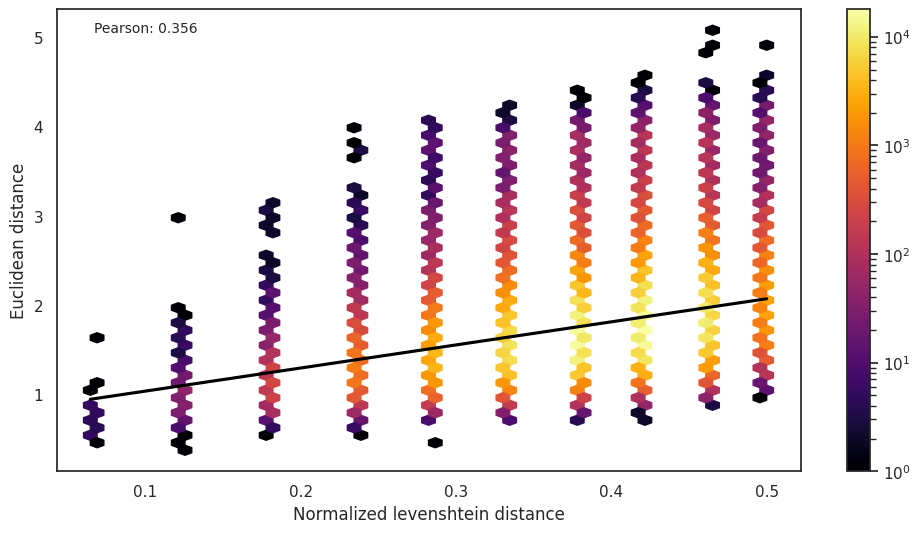

In [ ]:
sns.set_style("white")

plt.figure(figsize=(12, 6))

# Create a DataFrame
df_distances = pd.DataFrame({
    'Normalized levenshtein distance': levenshtein_list,
    'Euclidean distance': euclidean_list
})

# Hexbin plot
hb = plt.hexbin(df_distances['Normalized levenshtein distance'], df_distances['Euclidean distance'], gridsize=50, cmap='inferno', bins='log')
cb = plt.colorbar(hb)

# Regression line
sns.regplot(data=df_distances, x='Normalized levenshtein distance', y='Euclidean distance', scatter=False, color="black")

# Calculate the Pearson correlation coefficient separately
corr_coef, p_value = pearsonr(df_distances['Normalized levenshtein distance'], df_distances['Euclidean distance'])

# Annotate the plot with the Pearson correlation coefficient and p-value
plt.text(0.05, 0.95, f'Pearson: {corr_coef:.3f}', transform=plt.gca().transAxes, fontsize=10)

# Show the plot
plt.savefig('hb_1000.png')
plt.show()

In [ ]:
levenshtein_distances_hb = levenshtein_distances
euclidean_distances_hb = euclidean_distances

levenshtein_list_hb = levenshtein_list
euclidean_list_hb = euclidean_list

## **LB**

In [ ]:
dataframe = df_lb_1000

# Initialize dictionaries to store distances
levenshtein_distances = {}
euclidean_distances = {}

total_pairs = len(dataframe) * (len(dataframe) - 1) / 2  # Calculates the total number of sequence pairs

# Calculate pairwise distances
with tqdm(total=total_pairs, desc='Calculating distances', unit='pair') as pbar:
    for i in range(len(dataframe) - 1):
        for j in range(i + 1, len(dataframe)):
            # Levenshtein distance for sequences
            seq1 = dataframe.iloc[i]['junction_aa']
            seq2 = dataframe.iloc[j]['junction_aa']
            # https://rapidfuzz.github.io/Levenshtein/levenshtein.html#distance
            levenshtein_distances[(i, j)] = norm_dist(seq1, seq2)

            # Euclidean distance for embeddings
            embed1 = dataframe.iloc[i]['embedding']
            embed2 = dataframe.iloc[j]['embedding']
            euclidean_distances[(i, j)] = distance.euclidean(embed1, embed2)

            # Update the progress bar
            pbar.update()

# Display the results
print("Pairwise Levenshtein distances:", levenshtein_distances)
print("Pairwise Euclidean distances:", euclidean_distances)

Calculating distances: 100%|██████████| 499500/499500.0 [03:07<00:00, 2659.10pair/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




In [ ]:
# Extract the distances from the dictionaries into lists
levenshtein_list = list(levenshtein_distances.values())
euclidean_list = list(euclidean_distances.values())

# Calculate the Pearson correlation coefficient
correlation, p_value = pearsonr(levenshtein_list, euclidean_list)

print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value of the correlation: {p_value}")

Pearson correlation coefficient: 0.37285879358295765
P-value of the correlation: 0.0


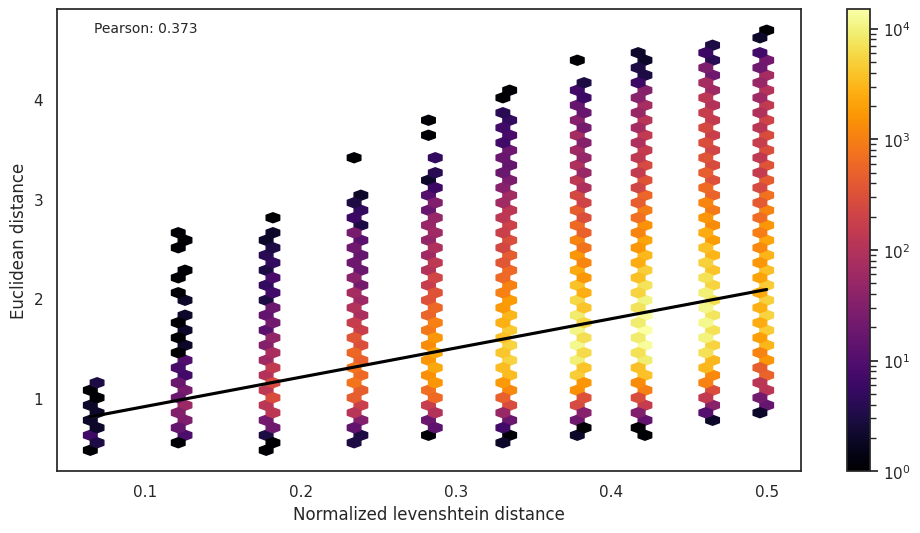

In [ ]:
sns.set_style("white")

plt.figure(figsize=(12, 6))

# Create a DataFrame
df_distances = pd.DataFrame({
    'Normalized levenshtein distance': levenshtein_list,
    'Euclidean distance': euclidean_list
})

# Hexbin plot
hb = plt.hexbin(df_distances['Normalized levenshtein distance'], df_distances['Euclidean distance'], gridsize=50, cmap='inferno', bins='log')
cb = plt.colorbar(hb)

# Regression line
sns.regplot(data=df_distances, x='Normalized levenshtein distance', y='Euclidean distance', scatter=False, color="black")

# Calculate the Pearson correlation coefficient separately
corr_coef, p_value = pearsonr(df_distances['Normalized levenshtein distance'], df_distances['Euclidean distance'])

# Annotate the plot with the Pearson correlation coefficient and p-value
plt.text(0.05, 0.95, f'Pearson: {corr_coef:.3f}', transform=plt.gca().transAxes, fontsize=10)

# Show the plot
plt.savefig('lb_1000.png')
plt.show()

In [ ]:
levenshtein_distances_lb = levenshtein_distances
euclidean_distances_lb = euclidean_distances

levenshtein_list_lb = levenshtein_list
euclidean_list_lb = euclidean_list

## **HB vs LB**

In [ ]:
levenshtein_distances = {}
euclidean_distances = {}

df_1 = df_hb_1000.sample(n=700, random_state=42)
df_2 = df_lb_1000.sample(n=700, random_state=42)

total_pairs = len(df_1) * len(df_2) # Updates the total number of sequence pairs

# Update progress bar total
with tqdm(total=total_pairs, desc='Calculating distances', unit='pair') as pbar:
    for i in range(len(df_1)):
        for j in range(len(df_2)):
            # Levenshtein distance for sequences
            seq1 = df_1.iloc[i]['junction_aa']
            seq2 = df_2.iloc[j]['junction_aa']
            # https://rapidfuzz.github.io/Levenshtein/levenshtein.html#distance
            levenshtein_distances[(i, j)] = norm_dist(seq1, seq2)

            # Euclidean distance for embeddings
            embed1 = df_1.iloc[i]['embedding']
            embed2 = df_2.iloc[j]['embedding']
            euclidean_distances[(i, j)] = distance.euclidean(embed1, embed2)

            # Update the progress bar
            pbar.update()

# Display the results
print("Pairwise Levenshtein distances:", levenshtein_distances)
print("Pairwise Euclidean distances:", euclidean_distances)

Calculating distances: 100%|██████████| 490000/490000 [03:07<00:00, 2615.51pair/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




In [ ]:
# Extract the distances from the dictionaries into lists
levenshtein_list = list(levenshtein_distances.values())
euclidean_list = list(euclidean_distances.values())

# Calculate the Pearson correlation coefficient
correlation, p_value = pearsonr(levenshtein_list, euclidean_list)

print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value of the correlation: {p_value}")

Pearson correlation coefficient: 0.32530250884712225
P-value of the correlation: 0.0


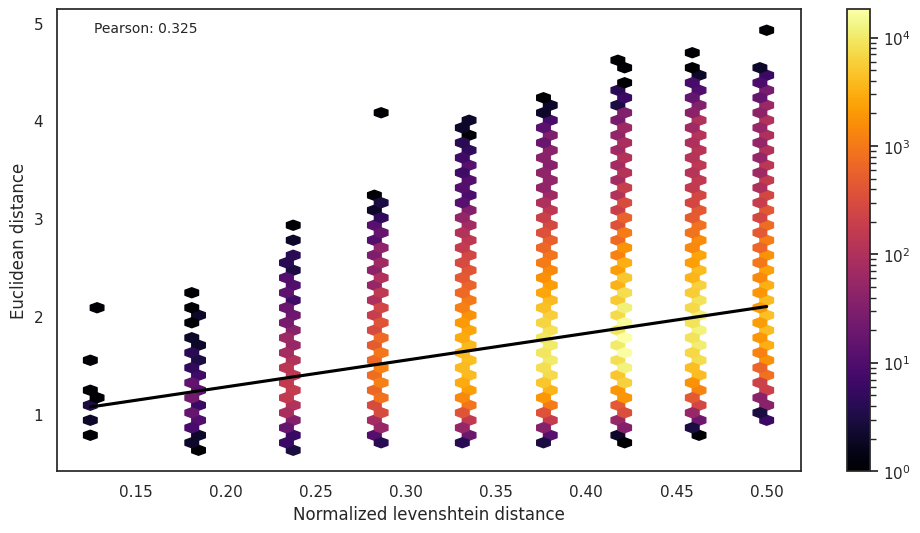

In [ ]:
sns.set_style("white")

plt.figure(figsize=(12, 6))

# Create a DataFrame
df_distances = pd.DataFrame({
    'Normalized levenshtein distance': levenshtein_list,
    'Euclidean distance': euclidean_list
})

# Hexbin plot
hb = plt.hexbin(df_distances['Normalized levenshtein distance'], df_distances['Euclidean distance'], gridsize=50, cmap='inferno', bins='log')
cb = plt.colorbar(hb)

# Regression line
sns.regplot(data=df_distances, x='Normalized levenshtein distance', y='Euclidean distance', scatter=False, color="black")

# Calculate the Pearson correlation coefficient separately
corr_coef, p_value = pearsonr(df_distances['Normalized levenshtein distance'], df_distances['Euclidean distance'])

# Annotate the plot with the Pearson correlation coefficient and p-value
plt.text(0.05, 0.95, f'Pearson: {corr_coef:.3f}', transform=plt.gca().transAxes, fontsize=10)

# Show the plot
plt.savefig('hb_lb_1000.png')
plt.show()

In [ ]:
levenshtein_distances_hb_lb = levenshtein_distances
euclidean_distances_hb_lb = euclidean_distances

levenshtein_list_hb_lb = levenshtein_list
euclidean_list_hb_lb = euclidean_list

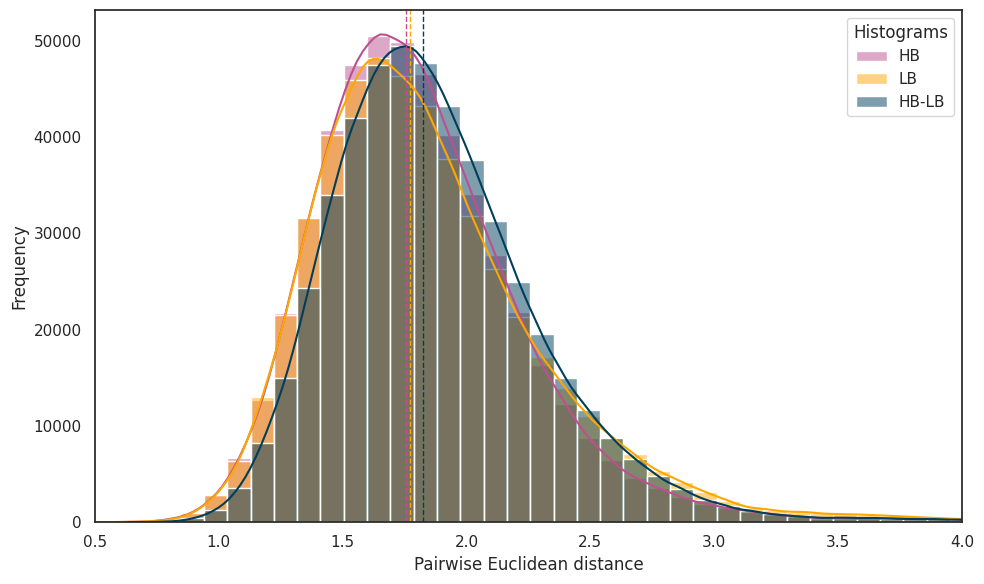

In [ ]:
hblb = euclidean_list_hb_lb
hb = euclidean_list_hb
lb = euclidean_list_lb

# Calculate median
median_hb_lb = np.median(hblb)
median_hb = np.median(hb)
median_lb = np.median(lb)

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Calculate common bins for all histograms
all_values = hblb + hb + lb
min_bin = min(all_values)
max_bin = max(all_values)
bin_width = (max_bin - min_bin) / 50  # Specify number of bins you want
bins = np.arange(min_bin, max_bin + bin_width, bin_width)

# Draw the histograms using the same bins for all distributions
sns.histplot(hb, color="#bc5090", label="HB", kde=True, bins=bins)
sns.histplot(lb, color="#ffa600", label="LB", kde=True, bins=bins)
sns.histplot(hblb, color="#003f5c", label="HB-LB", kde=True, bins=bins)

# Plot the medians
plt.axvline(median_hb, color='#bc5090', linestyle='dashed', linewidth=1)
plt.axvline(median_lb, color='#ffa600', linestyle='dashed', linewidth=1)
plt.axvline(median_hb_lb, color='#003f5c', linestyle='dashed', linewidth=1)

# Add legend, labels and title
plt.legend(title='Histograms')
plt.xlabel('Pairwise Euclidean distance')
plt.ylabel('Frequency')

plt.xlim(0.5, 4.0)

# Display the plot
plt.tight_layout()
plt.savefig('hist_euclidean.png')  # Changed file name to match the plot content
plt.show()

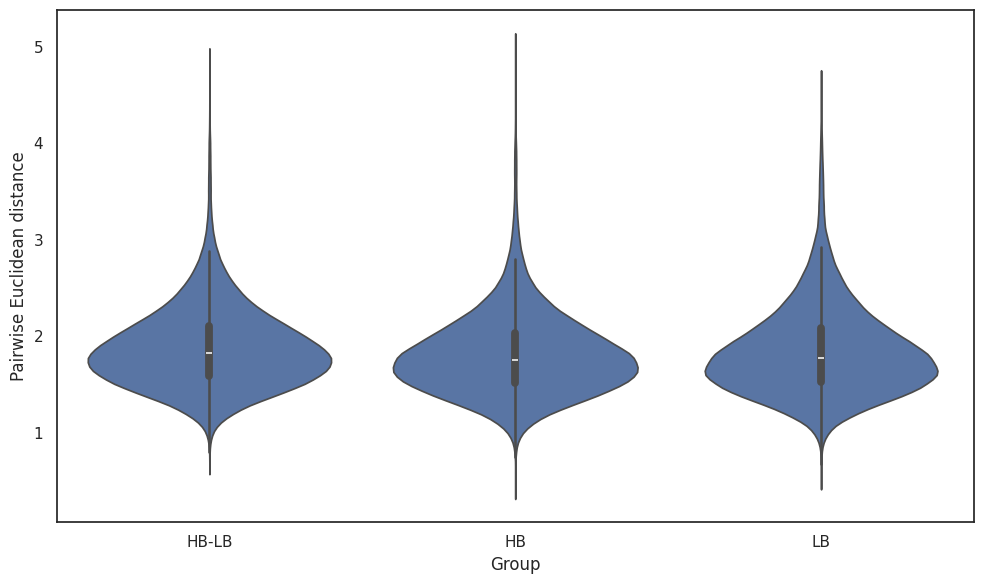

In [ ]:
hblb = euclidean_list_hb_lb
hb = euclidean_list_hb
lb = euclidean_list_lb

# Create a DataFrame for seaborn with a long form structure
data = {
    'Group': ['HB-LB']*len(hblb) + ['HB']*len(hb) + ['LB']*len(lb),
    'Distance': hblb + hb + lb
}
df = pd.DataFrame(data)

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Draw the Violin plot
sns.violinplot(x='Group', y='Distance', data=df)

# Add labels and title
plt.xlabel('Group')
plt.ylabel('Pairwise Euclidean distance')

# Save and display the plot
plt.tight_layout()
plt.savefig('violin_euclidean.png')
plt.show()

<ipython-input-40-9a164516e55e>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y='Distance', data=df, palette=palette)


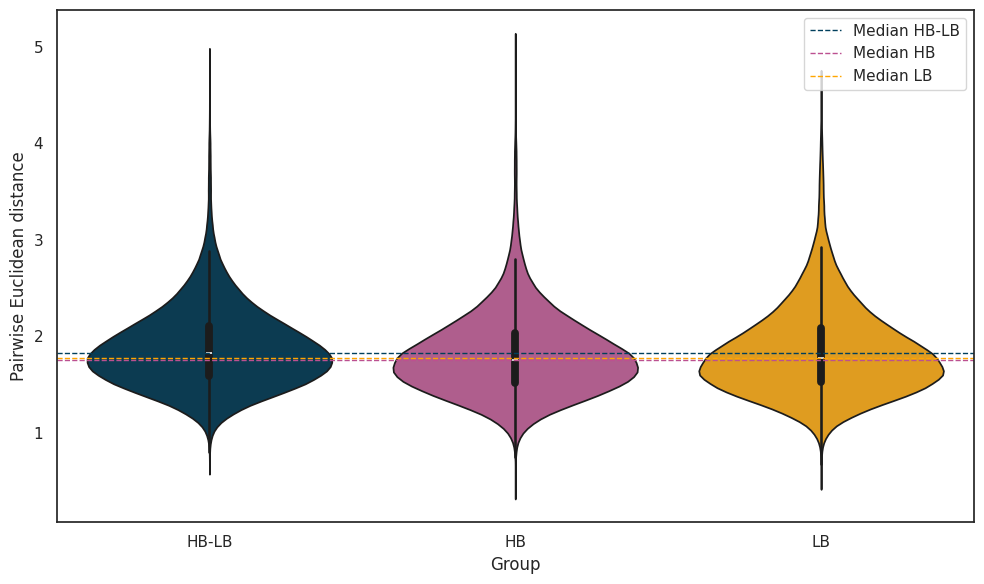

In [ ]:
hblb = euclidean_list_hb_lb
hb = euclidean_list_hb
lb = euclidean_list_lb

# Calculate medians for each group
median_hb_lb = np.median(hblb)
median_hb = np.median(hb)
median_lb = np.median(lb)

# Create a DataFrame for seaborn
df = pd.DataFrame({
    'Group': ['HB-LB'] * len(hblb) + ['HB'] * len(hb) + ['LB'] * len(lb),
    'Distance': hblb + hb + lb
})

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Set custom colors for the violins
palette = {'HB-LB': '#003f5c', 'HB': '#bc5090', 'LB': '#ffa600'}

# Draw the Violin plot
sns.violinplot(x='Group', y='Distance', data=df, palette=palette)

# Add a horizontal line for each median
# The x parameter here is the xticks of the plot. Since we have three categories ['HB-LB', 'HB', 'LB'],
# their xticks would be 0, 1, 2 respectively.
plt.axhline(median_hb_lb, color='#003f5c', linestyle='dashed', linewidth=1, label='Median HB-LB')
plt.axhline(median_hb, color='#bc5090', linestyle='dashed', linewidth=1, label='Median HB')
plt.axhline(median_lb, color='#ffa600', linestyle='dashed', linewidth=1, label='Median LB')

# Add labels and title
plt.xlabel('Group')
plt.ylabel('Pairwise Euclidean distance')

# Show legend
plt.legend()

# Save and display the plot
plt.tight_layout()
plt.savefig('violin_euclidean.png')
plt.show()

In [ ]:
print(mannwhitneyu(hb, hblb))
print(mannwhitneyu(lb, hblb))
print(mannwhitneyu(hb, lb))

#print('Jensen-Shannon distance: {}'.format(jensenshannon(hb, hblb)))
#print('Jensen-Shannon distance: {}'.format(jensenshannon(lb, hblb)))
#print('Jensen-Shannon distance: {}'.format(jensenshannon(hb, lb)))

MannwhitneyuResult(statistic=110014758581.0, pvalue=0.0)
MannwhitneyuResult(statistic=114194857659.5, pvalue=0.0)
MannwhitneyuResult(statistic=120974514745.5, pvalue=2.8398939163315853e-151)


In [ ]:
print(np.median(hb))
print(np.median(lb))
print(np.median(hblb))

1.7563797235488892
1.7706363797187805
1.8236417174339294


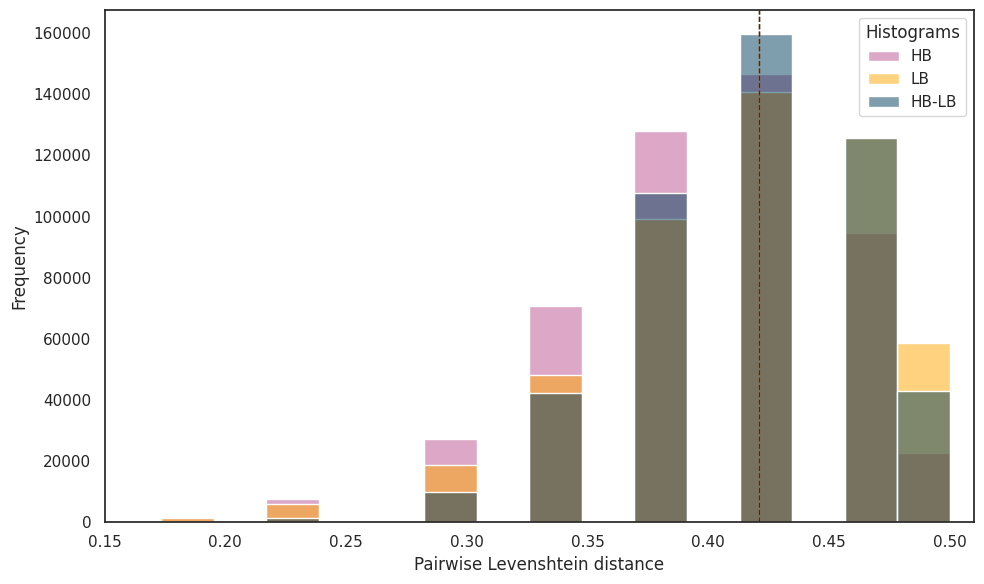

In [ ]:
hblb = levenshtein_list_hb_lb
hb = levenshtein_list_hb
lb = levenshtein_list_lb

# Calculate medians
median_hb_lb = np.median(hblb)
median_hb = np.median(hb)
median_lb = np.median(lb)

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Calculate common bins for all histograms
all_values = hblb + hb + lb
min_bin = min(all_values)
max_bin = max(all_values)
bin_width = (max_bin - min_bin) / 20  # Specify number of bins you want
bins = np.arange(min_bin, max_bin + bin_width, bin_width)

# Draw the histograms using the same bins for all distributions
sns.histplot(hb, color="#bc5090", label="HB", kde=False, bins=bins, alpha=0.5)
sns.histplot(lb, color="#ffa600", label="LB", kde=False, bins=bins, alpha=0.5)
sns.histplot(hblb, color="#003f5c", label="HB-LB", kde=False, bins=bins, alpha=0.5)

# Plot the medians
plt.axvline(median_hb, color='#bc5090', linestyle='dashed', linewidth=1)
plt.axvline(median_lb, color='#ffa600', linestyle='dashed', linewidth=1)
plt.axvline(median_hb_lb, color='#003f5c', linestyle='dashed', linewidth=1)

# Add legend, labels and title
plt.legend(title='Histograms')
plt.xlabel('Pairwise Levenshtein distance')
plt.ylabel('Frequency')

plt.xlim(0.15, 0.51)

# Display the plot
plt.tight_layout()
plt.savefig('hist_levenshtein.png')  # Changed file name to match the plot content
plt.show()

<ipython-input-42-8ad8369eb504>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y='Distance', data=df, palette=palette)


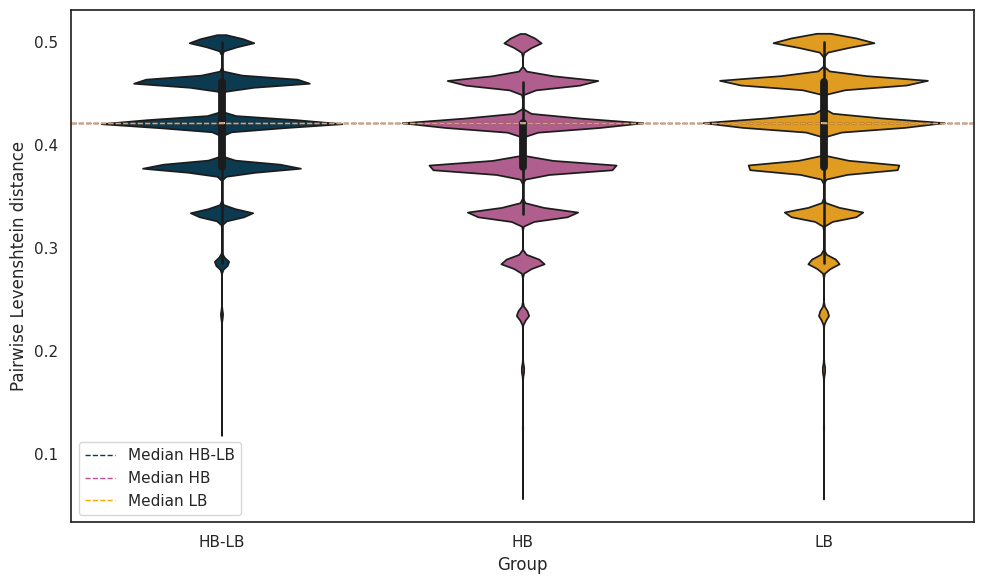

In [ ]:
hblb = levenshtein_list_hb_lb
hb = levenshtein_list_hb
lb = levenshtein_list_lb

# Calculate medians for each group
median_hb_lb = np.median(hblb)
median_hb = np.median(hb)
median_lb = np.median(lb)

# Create a DataFrame for seaborn
df = pd.DataFrame({
    'Group': ['HB-LB'] * len(hblb) + ['HB'] * len(hb) + ['LB'] * len(lb),
    'Distance': hblb + hb + lb
})

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Set custom colors for the violins
palette = {'HB-LB': '#003f5c', 'HB': '#bc5090', 'LB': '#ffa600'}

# Draw the Violin plot
sns.violinplot(x='Group', y='Distance', data=df, palette=palette)

# Add a horizontal line for each median
# The x parameter here is the xticks of the plot. Since we have three categories ['HB-LB', 'HB', 'LB'],
# their xticks would be 0, 1, 2 respectively.
plt.axhline(median_hb_lb, color='#003f5c', linestyle='dashed', linewidth=1, label='Median HB-LB')
plt.axhline(median_hb, color='#bc5090', linestyle='dashed', linewidth=1, label='Median HB')
plt.axhline(median_lb, color='#ffa600', linestyle='dashed', linewidth=1, label='Median LB')

# Add labels and title
plt.xlabel('Group')
plt.ylabel('Pairwise Levenshtein distance')

# Show legend
plt.legend()

# Save and display the plot
plt.tight_layout()
plt.savefig('violin_levenshtein.png')
plt.show()

In [ ]:
print(len(hb))
print(len(lb))
print(len(hblb))

499500
499500
490000


In [ ]:
print(mannwhitneyu(hb, hblb))
print(mannwhitneyu(lb, hblb))
print(mannwhitneyu(hb, lb))

MannwhitneyuResult(statistic=98656942012.5, pvalue=0.0)
MannwhitneyuResult(statistic=122294479049.0, pvalue=0.5476253733973973)
MannwhitneyuResult(statistic=102248874524.5, pvalue=0.0)


In [ ]:
print(np.median(hb))
print(np.median(lb))
print(np.median(hblb))

0.42105263157894735
0.42105263157894735
0.42105263157894735


In [ ]:
tensors[0]

array([ 0.0165359 ,  0.09836441,  0.08451218, ...,  0.02045532,
       -0.00949972,  0.04278376], dtype=float32)

In [ ]:
distance.euclidean(tensors[1], tensors[0])

1.7437975406646729